In [3]:
import requests
from bs4 import BeautifulSoup
from urllib.parse import urljoin, urlparse 
import csv
import os
import re

BASE_URL = 'https://genshin-builds.com'
WEAPONS_URL = urljoin(BASE_URL, "/en/weapons")
WEAPONS_PATH = '../data/weapons.csv'
IMAGE_DIR = '../images/weapon_icons' 

os.makedirs(os.path.dirname(WEAPONS_PATH), exist_ok=True)
os.makedirs(IMAGE_DIR, exist_ok=True)
print(f"Data will be saved to: {WEAPONS_PATH}")
print(f"Images will be saved to: {IMAGE_DIR}\n")

# --- NEW: Helper function to normalize text for comparison ---
def normalize_text(text):
    """Removes special chars, spaces, and casing to compare URLs vs Names."""
    # e.g. "Wolf's Gravestone" -> "wolfsgravestone"
    # e.g. "wolfs-gravestone" -> "wolfsgravestone"
    return re.sub(r'[^\w]', '', text.lower())

# --- NEW: Load existing weapons into a set ---
existing_slugs = set()
if os.path.exists(WEAPONS_PATH):
    try:
        with open(WEAPONS_PATH, 'r', encoding='utf-8') as f:
            reader = csv.DictReader(f)
            for row in reader:
                if 'name' in row and row['name']:
                    existing_slugs.add(normalize_text(row['name']))
        print(f"Loaded {len(existing_slugs)} existing weapons from database.\n")
    except Exception as e:
        print(f"Warning: Could not read existing CSV ({e}). Starting fresh.\n")

response = requests.get(WEAPONS_URL)
soup = BeautifulSoup(response.content, 'html.parser')
weapon_links = soup.select('a[href^="/en/weapon"]')[2:]
weapon_links = [urljoin(BASE_URL, w['href']) for w in weapon_links]

new_weapons_count = 0

for link in weapon_links:
    # --- NEW: Check if weapon exists before scraping ---
    # We extract the slug from the URL (e.g., 'wolfs-gravestone') and normalize it
    # to compare against the names we loaded from the CSV.
    url_slug = link.strip('/').split('/')[-1]
    if normalize_text(url_slug) in existing_slugs:
        # print(f"Skipping {url_slug} (already exists)") # Uncomment for verbose output
        continue

    print(f"Scraping new weapon: {link}")
    
    try:
        response = requests.get(link)
        response.raise_for_status()
        soup = BeautifulSoup(response.content, 'html.parser')

        #weapon name
        name_element = soup.select_one('h1')
        name = name_element.get_text(strip=True).replace('Genshin Impact', '').replace('Weapon', '').strip() if name_element else "N/A"

        #type
        type_element = soup.select_one('div.flex-wrap span img')
        weapon_type = type_element['alt'] if type_element else "N/A"

        #rarity
        rarity = "N/A"
        rarity_container = soup.select_one('div[class*="genshin-bg-rarity-"]')
        if rarity_container:
            rarity_class = next((cls for cls in rarity_container['class'] if 'genshin-bg-rarity-' in cls), None)
            if rarity_class:
                rarity = int(rarity_class.split('-')[-1])

        #download icon
        icon_element = soup.select_one('div.relative.mb-3.flex-none img')
        icon_url = icon_element['src'] if icon_element else None
        icon_path = "N/A"

        if icon_url:
            sanitized_name = re.sub(r'[\\/*?:"<>|]', "", name).replace(' ', '_').lower()
            parsed_url = urlparse(icon_url)
            file_extension = os.path.splitext(parsed_url.path)[1] or '.png'
            filename = f"{sanitized_name}{file_extension}"
            icon_path = os.path.join(IMAGE_DIR, filename)

            # --- NEW: Check if image exists before downloading ---
            if not os.path.exists(icon_path):
                try:
                    img_response = requests.get(icon_url)
                    img_response.raise_for_status()
                    with open(icon_path, 'wb') as f:
                        f.write(img_response.content)
                    print(f"  -> Downloaded icon to {icon_path}")
                except requests.exceptions.RequestException as e:
                    print(f"  -> 🚨 Failed to download image: {e}")
            else:
                 print(f"  -> Icon already exists at {icon_path}")

        weapon_info = {
            'name': name,
            'type': weapon_type,
            'rarity': rarity,
            'icon_path': icon_path
        }

        # --- NEW: Append immediately to CSV ---
        # We open in 'a' (append) mode. 
        # We write the header only if the file is new/empty.
        file_is_empty = not os.path.exists(WEAPONS_PATH) or os.stat(WEAPONS_PATH).st_size == 0
        
        with open(WEAPONS_PATH, 'a', newline='', encoding='utf-8') as csvfile:
            fieldnames = ['name', 'type', 'rarity', 'icon_path']
            writer = csv.DictWriter(csvfile, fieldnames=fieldnames)

            if file_is_empty:
                writer.writeheader()
            
            writer.writerow(weapon_info)
            new_weapons_count += 1
            
            # Update our in-memory set so we don't scrape duplicates within the same run
            existing_slugs.add(normalize_text(name))

    except Exception as e:
        print(f"Error scraping {link}: {e}")

print(f"\n✅ Finished! Added {new_weapons_count} new weapons.")

Data will be saved to: ../data/weapons.csv
Images will be saved to: ../images/weapon_icons

Scraping new weapon: https://genshin-builds.com/en/weapon/a_thousand_blazing_suns
  -> Icon already exists at ../images/weapon_icons/a_thousand_blazing_suns.png
Scraping new weapon: https://genshin-builds.com/en/weapon/a_thousand_floating_dreams
  -> Icon already exists at ../images/weapon_icons/a_thousand_floating_dreams.png
Scraping new weapon: https://genshin-builds.com/en/weapon/absolution
  -> Icon already exists at ../images/weapon_icons/absolution.png
Scraping new weapon: https://genshin-builds.com/en/weapon/amos_bow
  -> Icon already exists at ../images/weapon_icons/amos'_bow.png
Scraping new weapon: https://genshin-builds.com/en/weapon/aqua_simulacra
  -> Icon already exists at ../images/weapon_icons/aqua_simulacra.png
Scraping new weapon: https://genshin-builds.com/en/weapon/aquila_favonia
  -> Icon already exists at ../images/weapon_icons/aquila_favonia.png
Scraping new weapon: https:

<!DOCTYPE html>
<html lang="en"> <head><meta content="184302aed06fab35603b7bdc3642ec61-093ccb5f6fa133d4-1" name="sentry-trace"/>
<meta content="sentry-environment=production,sentry-release=9016d4a64b1d649b74b048fbaf09f362ae24b36d,sentry-public_key=9c7422fbfed53fb87f55bc455bb22a83,sentry-trace_id=184302aed06fab35603b7bdc3642ec61,sentry-org_id=95426,sentry-transaction=GET%20%2F%5Blang%5D%2Fweapon%2F%5Bid%5D,sentry-sampled=true,sentry-sample_rand=0.008060352716249497,sentry-sample_rate=1" name="baggage"/>
<meta content="%2F%5Blang%5D%2Fweapon%2F%5Bid%5D" name="sentry-route-name"/><meta charset="utf-8"/><meta content="width=device-width, initial-scale=1" name="viewport"/><meta content="Astro v5.14.1" name="generator"/><link href="https://genshin-builds.com/sitemap.xml" rel="alternate" title="RSS Feed for Genshin Builds" type="application/rss+xml"/><script type="application/ld+json">{"@context":"https://schema.org","@type":"BreadcrumbList","itemListElement":[{"@type":"ListItem","position":1
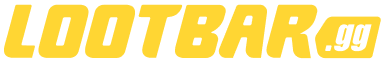

In [4]:
soup